# Phylogic Reviewer

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from JupyterReviewer.Reviewers.PhylogicReviewer import PhylogicReviewer
from JupyterReviewer.ReviewData import ReviewDataAnnotation
from JupyterReviewer.ReviewDataApp import AppComponent

import pandas as pd
from dash import html

## Edit the code below according to the commented directions

In [24]:
pd.read_csv(f'/Users/cmesser/Documents/Projects/participant_reviewer/participant_75.tsv', sep='\t').set_index('entity:participant_id')

,seg_cluster,PhylogicNDT_cell_population_mcmc_trace,cluster_ccfs,mut_ccfs,PhylogicNDT_tree_tsv,PhylogicNDT_unclustered_muts
entity:participant_id,,,,,,
GBM.ICB-75,gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d9682...,gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d9682...,gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d9682...,gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d9682...,gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d9682...,gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d9682...


In [81]:
reviewer = PhylogicReviewer()

reviewer.set_review_data(
    # Enter the file path where you would like your pkl file of your review data to be stored
    review_data_fn='../test_Phylogic_Reviewer_8.pkl',
    # Breifly describe the source of your data and its purpose
    description='Test phylogic review',
    # Enter the file path to your data to be reviewed
    df=pd.read_csv(f'/Users/cmesser/Documents/Projects/participant_reviewer/participant_75.tsv', sep='\t').set_index('entity:participant_id'),
    review_data_annotation_dict=None
)

reviewer.set_review_app(sample_data_df=pd.read_csv('/Users/cmesser/Documents/Projects/participant_reviewer/pairs_75.tsv', sep='\t').set_index('entity:pair_id'))

## Run

In [82]:
reviewer.run(mode='external', port=8088)

Dash app running on http://0.0.0.0:8088/


In [101]:
sample_data_df=pd.read_csv('/Users/cmesser/Documents/Projects/participant_reviewer/pairs_75.tsv', sep='\t').set_index('entity:pair_id')
data_df = pd.read_csv(f'/Users/cmesser/Documents/Projects/participant_reviewer/participant_75.tsv', sep='\t').set_index('entity:participant_id')
from cnv_suite import switch_contigs
mut_ccfs_df = switch_contigs(pd.read_csv(data_df.loc['GBM.ICB-75']['mut_ccfs'], sep='\t'))
mut_ccfs_df['Chromosome'] = mut_ccfs_df['Chromosome'].astype(int)  # todo change
seg_df = []
for sample_id in sample_data_df.sort_values('collection_date_dfd').index.tolist():
    this_seg_df = pd.read_csv(sample_data_df.loc[sample_id, 'alleliccapseg_tsv'], sep='\t')
    this_seg_df['Sample_ID'] = sample_id
    seg_df.append(this_seg_df)
seg_trees = cnv_suite.get_segment_interval_trees(pd.concat(seg_df))

In [102]:
tup = seg_trees[22][10000000].pop().data['GBM.ICB-75-19.778.A1-Post3']

In [103]:
mut_ccfs_df = cnv_suite.apply_segment_data_to_df(mut_ccfs_df, seg_trees)

KeyError: 'pop from an empty set'

In [62]:
seg_df = []
for sample_id in sample_data_df.sort_values('collection_date_dfd').index.tolist():
    this_seg_df = pd.read_csv(sample_data_df.loc[sample_id, 'alleliccapseg_tsv'], sep='\t')
    this_seg_df['Sample_ID'] = sample_id
    seg_df.append(this_seg_df)

In [63]:
import cnv_suite
seg_trees = cnv_suite.get_segment_interval_trees(pd.concat(seg_df))

In [77]:
seg_trees[22][10000000].pop().data['GBM.ICB-75-19.778.A1-Post3_pair']

Data_Tuple(n_probes=512.0, length=46014200.0, n_hets=0.0, f=1.0, tau=1.92736020387392, sigma_tau=0.0088302649739119, mu_minor=0.001, sigma_minor=1e-05, mu_major=0.96368010193696, sigma_major=0.0044151324869559, SegLabelCNLOH=2.0, Cluster_assignment='0')

In [59]:
pd.concat(seg_df.values())

,Chromosome,Start.bp,End.bp,n_probes,length,n_hets,f,tau,sigma.tau,mu.minor,sigma.minor,mu.major,sigma.major,SegLabelCNLOH
0,1,3301782,247769352,10328,244467570,1246,0.5,2.008057,0.001671,1.004028,0.000902,1.004028,0.000902,2
1,2,669714,242447435,7669,241777721,866,0.5,2.018693,0.001949,1.009347,0.001324,1.009347,0.001324,2
2,3,2861217,197518280,6216,194657063,797,0.5,2.017244,0.002163,1.008622,0.001343,1.008622,0.001343,2
3,4,1067055,187629348,3988,186562293,544,0.5,2.038958,0.002730,1.019479,0.001862,1.019479,0.001862,2
4,5,916053,139941102,3056,139025049,369,0.5,2.034637,0.003112,1.017318,0.002184,1.017318,0.002184,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,22,38504103,38506506,3,2403,0,NaN,1.312567,0.092936,NaN,NaN,NaN,NaN,2
500,22,38508375,49145654,783,10637279,70,0.5,1.874862,0.008202,0.937431,0.006140,0.937431,0.006140,2
501,23,3228710,49242910,512,46014200,0,1.0,1.943732,0.012962,0.001000,0.000010,0.971866,0.006481,2
502,23,49301489,49361324,14,59835,0,1.0,1.010432,0.040878,0.001000,0.000010,0.505216,0.020439,2


### Test plotting

In [11]:
#from PhylogicReviewer import ccf_pmf_plot
import pandas as pd
import re
import plotly.express as px

df = pd.DataFrame([['ONC106612', 'gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/1dc35867-4c57-487e-bcdd-e39820462211/phylogicndt/b007b77f-c150-490f-9d55-7ace9eb495dd/call-clustering/ONC106612.mut_ccfs.txt'], ['ONC110293', 'gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/1dc35867-4c57-487e-bcdd-e39820462211/phylogicndt/598b3916-a3b8-49dd-a3cb-bfb8ab8cd08e/call-clustering/cacheCopy/ONC110293.mut_ccfs.txt']], columns=['participant_id', 'mut_ccfs'])
df.set_index('participant_id', inplace=True)
mut_ids = ['13:67799823C>A', '3:99568657T>C', '17:1558752G>A']
samples = ['17318_13_OCT_052219', '17318_13_BB_111119']


In [12]:
def ccf_pmf_plot(data_df, idx, mut_ids, sample_selection):
    """Plots the CCF pmf distribution for the chosen mutation(s).

    Notes
    -----
    - Displays the pmf distribution as a normalized histogram
    - Samples are shown in separate rows
    - Clusters displayed with different colors, with adjacent bars

    """
    mut_ccfs_df = pd.read_csv(data_df.loc[idx, 'mut_ccfs'], sep='\t')
    mut_ccfs_df['unique_mut_id'] = mut_ccfs_df.apply(get_unique_identifier, axis=1)
    chosen_muts_df = mut_ccfs_df[mut_ccfs_df['unique_mut_id'].isin(mut_ids)].copy()

    ccfs_headers = [re.search('.*[01].[0-9]+', i) for i in mut_ccfs_df.columns]
    ccfs_headers = [x.group() for x in ccfs_headers if x]

    #pmf_plot = make_subplots(1, len(sample_selection))
    stacked_muts = chosen_muts_df.set_index(['Sample_ID', 'unique_mut_id', 'Cluster_Assignment'])[
        ccfs_headers].stack().reset_index().rename(columns={'level_3': 'ccf_val', 0: 'pmf_val'})
    fig = px.histogram(stacked_muts, x='ccf_val', y='pmf_val', color='unique_mut_id', facet_row='Sample_ID', barmode='group', histfunc='avg')
    return fig


def get_unique_identifier(row, chrom='Chromosome', start_pos='Start_position',
                          ref='Reference_Allele', alt='Tumor_Seq_Allele'):
    """Generates unique string for this mutation, including contig, start position, ref and alt alleles.

    Does not include End Position, for this field is not present in mut_ccfs Phylogic output. However, specification of both the alt and ref alleles are enough to distinguish InDels.

    :param row: pd.Series giving the data for one mutation from a maf or maf-like dataframe
    :param chrom: the name of the contig/chromosome column/field; default: Chromosome
    :param start_pos: the name of the start position column/field; default: Start_position
    :param ref: the name of the reference allele column/field; default: Reference_Allele
    :param alt: the name of the alternate allele column/field; default: Tumor_Seq_Allele
    """
    return f"{row[chrom]}:{row[start_pos]}{row[ref]}>{row[alt]}"

In [13]:
fig = ccf_pmf_plot(df, 'ONC106612', mut_ids, samples)

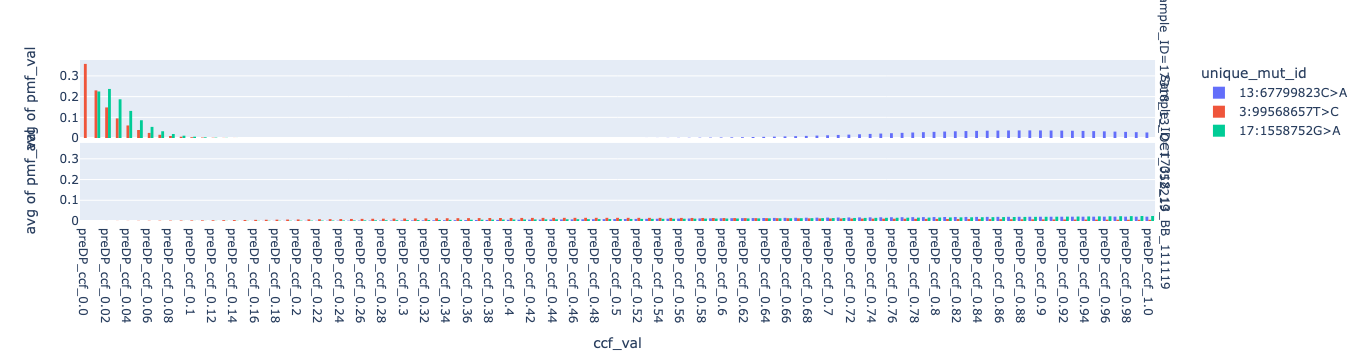

In [14]:
fig.show()